AML HW 3  
Yingyu Cao (yc3713)  
Bo Jumrustanasan (pj2356)

# Import Packges {-}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.compose import TransformedTargetRegressor

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
#import shap

from sklearn.feature_selection import SelectFromModel
#from sklearn.pipeline import make_pipeline

# Task 1 Identify Features {-}

## Load Data {-}
We subsampled 5000 data points from the orginal data. 

In [2]:
sample_v_1 = pd.read_csv("sample_vehicles1.csv")

## Data Cleaning {-}

We conducted the following steps to clean the data and identify features:

1. Keep only features that we think are useful for price prediction for further inspection. Almost all data points have unique `id`, `url`, `image_url`, `vin`, and `description`. If these features are included, a model may associate the value to the price and will not be able to generalize well. `description` also leaks target information because it contains the price in the text. We keep the following 16 features:

   * `Region`, `year`, `manufacturer`, `model`, `condition`, `cylinders`, `fuel`, `odometer`, `title_status`, `transmission`, `drive`, `size`, `type`, `paint_color`, `description`, `state`.

In [3]:
print("Unique ID: ", sample_v_1.id.unique().shape)
print("Unique URL: ", sample_v_1.url.unique().shape)
print("Unique IMAGE_URL: ", sample_v_1.image_url.unique().shape)
print("Unique DESCRIPTION: ", sample_v_1.description.unique().shape)
print("Unique VIN: ", sample_v_1.vin.unique().shape, "  Many observations have missing VIN")
print("Number of Obs with missing VIN: ", np.sum(sample_v_1.vin.isnull()))

Unique ID:  (5000,)
Unique URL:  (5000,)
Unique IMAGE_URL:  (4955,)
Unique DESCRIPTION:  (4972,)
Unique VIN:  (2878,)   Many observations have missing VIN
Number of Obs with missing VIN:  2087


2. Remove rows with outliers and unreasonable values. It is unreasonable for selling a (used) car for less than 1,000 or greater than 100,000; those with odometer higher than 1,000,000 are also treated as outliers. They are not a good representation of the data.
3. Convert `cylinders` (string) to numeric.

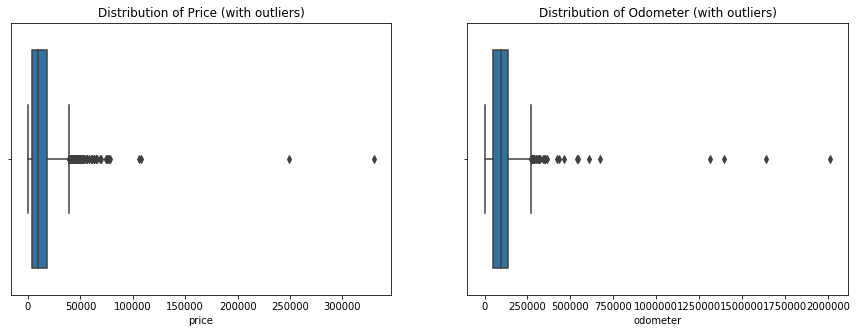

In [4]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
sns.boxplot(sample_v_1.price,ax=ax[0]);
sns.boxplot(sample_v_1.odometer,ax=ax[1]);
ax[0].set_title("Distribution of Price (with outliers)");
ax[1].set_title("Distribution of Odometer (with outliers)");

In [5]:
# default='warn'    mute warnings
pd.options.mode.chained_assignment = None  

## Features that are kept
features=['region','year', 'manufacturer','model', 'condition', 'cylinders', 
          'fuel', 'odometer','title_status' ,'transmission', 'drive', 'size',
          'type', 'paint_color', 'description', 'state']

# drop missing rows and outliers (# year missing=11, # price missing=166)
sample_v_1=sample_v_1[~((sample_v_1.price<1000)|(sample_v_1.price>100000)|(sample_v_1.odometer>1000000))]

y = sample_v_1.price
X = sample_v_1[features]

## Convert cylinders to numeric
X['cylinders']= X['cylinders'].str.replace(" cylinders", "", case = False)  # remove suffix in the cylinder col
X['cylinders']= X['cylinders'].apply(pd.to_numeric, errors='coerce')    # turn "other" into nan (#=7)

In [6]:
## Set global training and test sets
global_X_trainval, global_X_test, global_y_trainval, \
        global_y_test = train_test_split(X, y, random_state=1)

## Identify Features through Visualization {-}

In [7]:
categorical = ['region', 'description','title_status','model',
               'fuel','transmission', 'drive','type',
               'manufacturer','paint_color', 'state']
ordinal = ['condition','size','cylinders']
continuous = ['year','odometer']

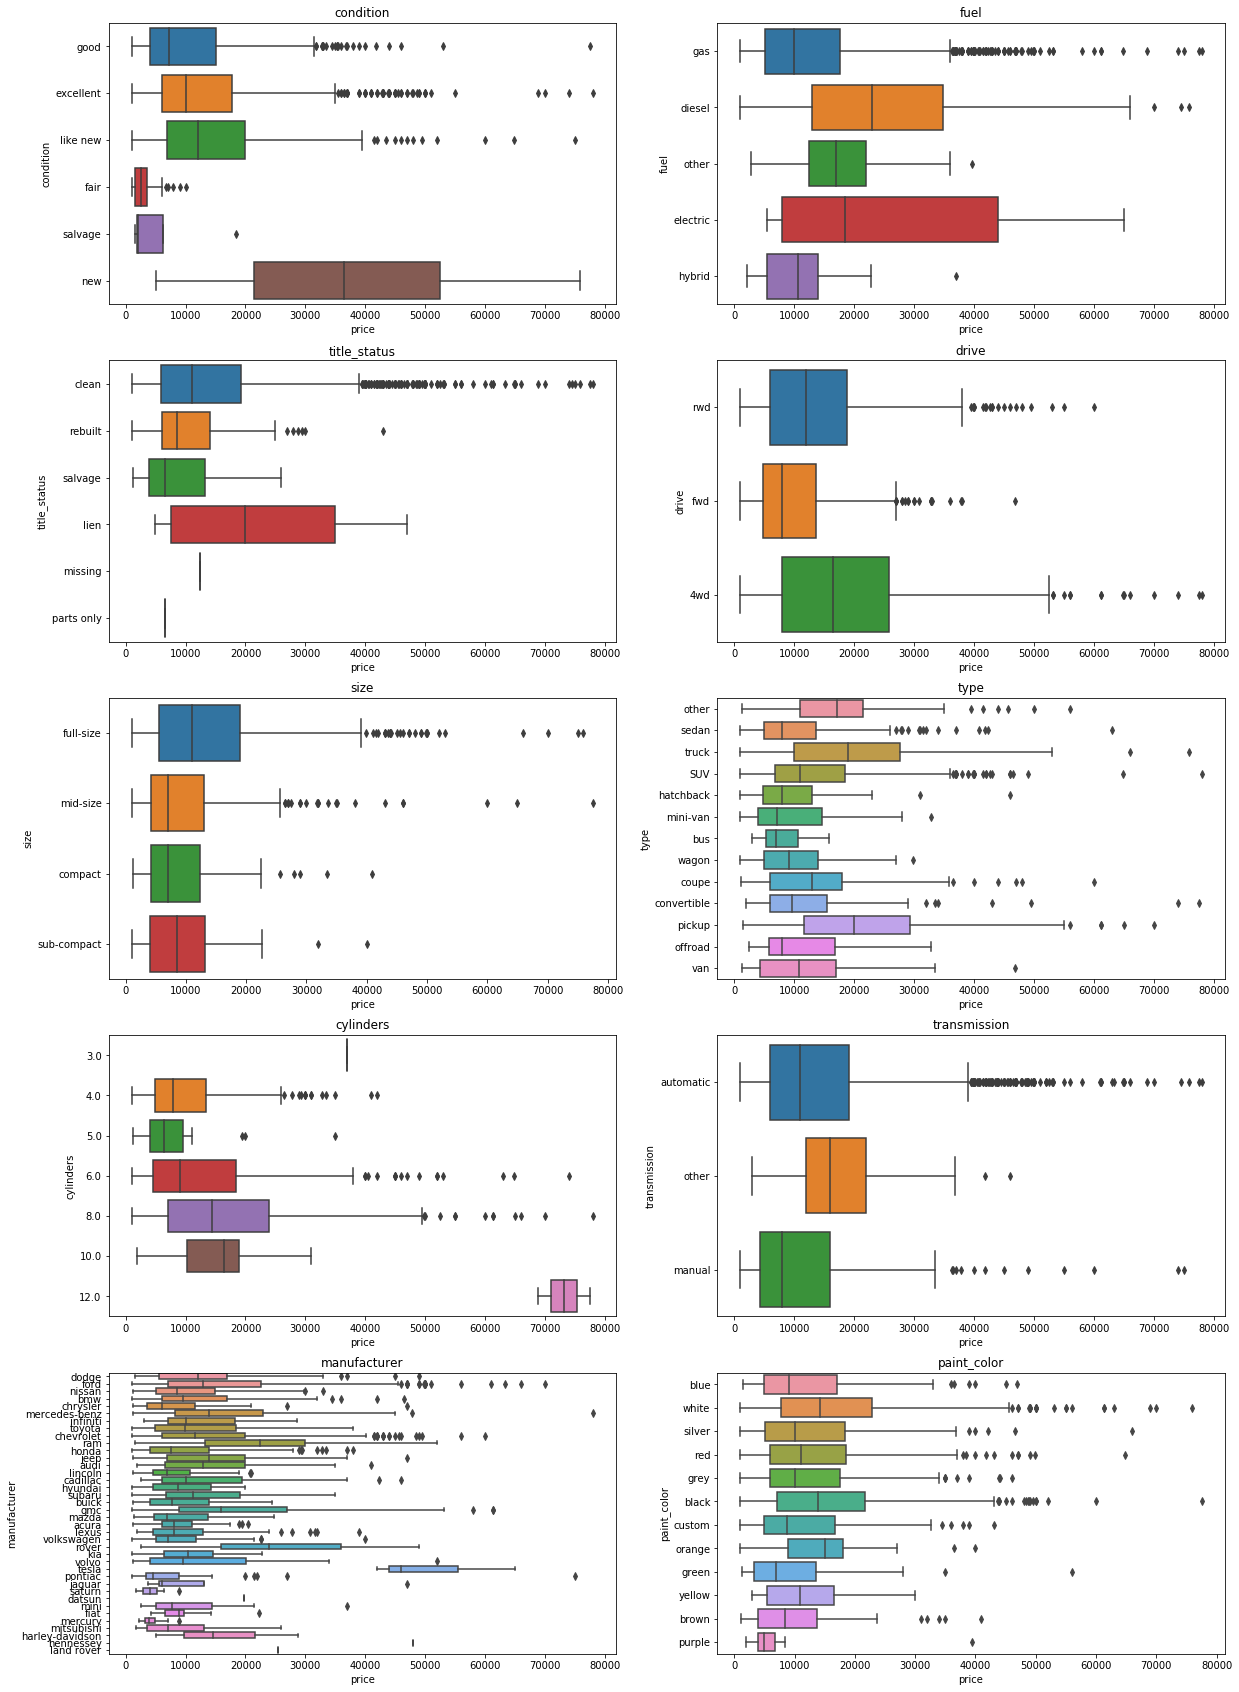

In [8]:
# boxplot for categorical variables using seaborn
feature=list(set(categorical+ordinal).difference(['region','model', 'description', 'state']))
fig,ax=plt.subplots(5,2,figsize=(20,30))
for i in range(0,5):
    for j in range(0,2):
        sns.boxplot(y=X[feature[i*2+j]],x=y,ax=ax[i,j],orient="h").set_title(feature[i*2+j])

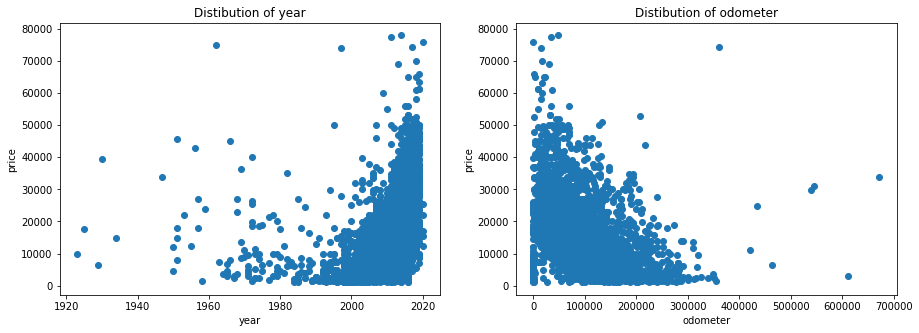

In [9]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
for i in range(0,2):
    ax[i].scatter(X[continuous[i]],y)
    ax[i].set_xlabel(continuous[i])
    ax[i].set_ylabel('price')
    ax[i].set_title('Distibution of {}'.format(continuous[i]))

We visualize univariate relationships between each feature (excluding `region`,` model`, `description`, `state`) and the target `price`. Some interesting features are: 

* `cylinder`:
   * Considering only common cylinders (4, 6, and 8), a car with 8 cylinders portrays higher price
   * 12 cylinder has distinctively high price (we found later that because there is only a couple of data points)
* `condition`:
   * Natural ordering intuitively reflect the price well. (New is the highest and salvage is the lowest.)
* `size`:
   * Full-size cars have the highest median price
* `year`: 
    * A newer model has a higher median price.
* `odometer`:
    * A car with high odometer has a lower median price.

No patterns are observed in other features due to too few data points (e.g. manufacturer Tesla has significantly high price). However, we decide to keep most of them for further inspection because they are intuitive predictors for the selling price. Features that we drop are `region`, `description`, `title_status`, and `model`. We belive that the variation in `state` is more informative than in `region`. `description` and `model` are so specific that there will be only few data points with a certain value, which does not do any good to model training.

## Missing Values {-}

* We found that the missing correlations of a feature pair are so low that we consider it missing at random. This justifies a complete case analysis in further process.

In [10]:
## percent missing in each feature
missing_per=(X.isnull().sum()[X.isnull().sum()>0]/X.shape[0]).sort_values(axis='index',ascending=False)
print("missing percentage:\n{}".format(missing_per))

missing percentage:
size            0.671719
condition       0.425792
cylinders       0.389593
paint_color     0.316290
type            0.278054
drive           0.266968
odometer        0.163122
manufacturer    0.044344
model           0.014932
fuel            0.006787
transmission    0.006561
title_status    0.004072
year            0.002489
dtype: float64


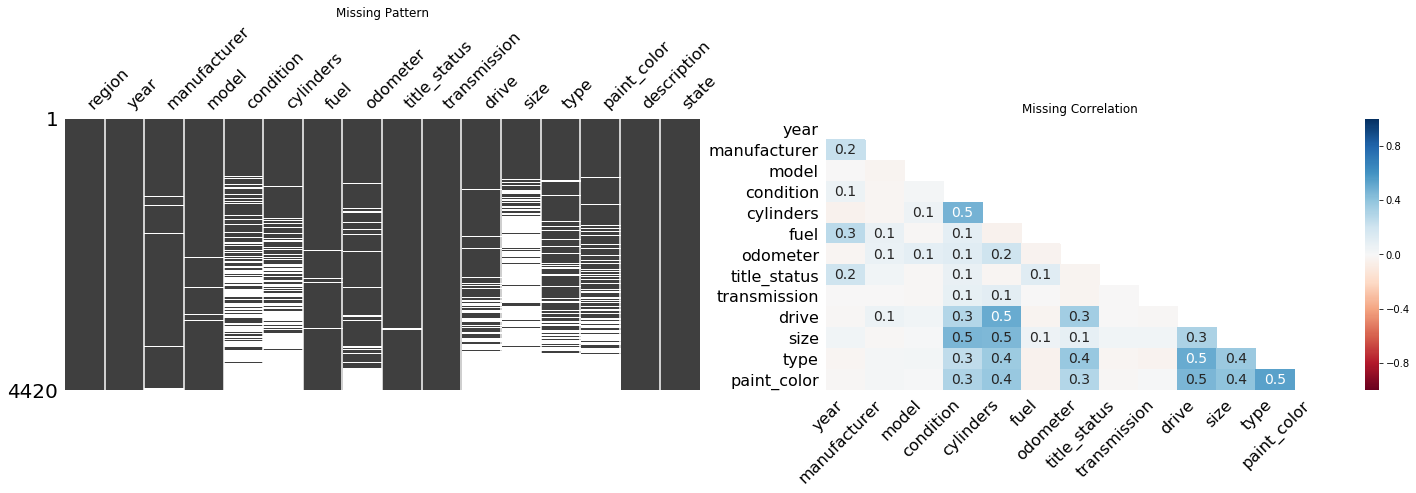

In [11]:
## White = missing
## Ideally want 0 missing correlation
fig,ax = plt.subplots(1,2, figsize=(25,5))
msno.matrix(X, sort="descending", sparkline=False, ax=ax[0])
msno.heatmap(X, figsize=(10,5), ax=ax[1])
ax[0].set_title('Missing Pattern')
ax[1].set_title('Missing Correlation')
missing=['size','condition','cylinders']   # top 3 missing columns

* Left: White indicates missing
* Right: Perfectly incorrelated is represented as 0

# Task 2 Preprocessing and Baseline Model {-}

## Preprocessing {-}
We consider the features as:

* Continuous: `year`, `odometer`
* Categorical: `region`, `description`, `title_status`, `model`, `fuel`, `transmission`, `drive`, `type`, `manufacturer`, `paint_color`, `state`
* Ordinal: `condition`, `size`, `cylinders`

We preprocessed the data in following steps:

* drop `region`, `description`, `title_status`, and `model`
* dealing with missing values (imputation and/or complete cases)
* standardize `odometer` (we did not standardize `year` because it does not make sense)
* target encode `state`
* one-hot encode other categprical variables
* transform output `price` into log form

In [12]:
def complete_cases(X, y, dropped_col, imputed_col = []):
    """Drop rows that contain missing values in cols that will
    never be imputed.
    
    @param A pair X and y whose indices align.
    @param dropped_col column names to be dropped.
    @param imputed_col columns names that will later be imputed.
    
    @return complete-cased X and y."""
    X_dropped = X.drop(columns=dropped_col, inplace=False)
    other_col = list(set(X_dropped.columns).difference(imputed_col))
    
    keep = ~X_dropped[other_col].isna().any(axis=1)
    X_complete = X_dropped[keep]
    y_complete = y[keep]
    
    return X_complete, y_complete

In [13]:
def grid_result_imp(drop, continuous, target, categorical, param_grid, \
                    X_trainval, y_trainval, missing_imp=[], cv=5, impute = True):
    """
    Process and apply a grid search CV on X_trainval and y_trainval.
    @param X_trainval and y_trainval
    @return grid object that is fitted on complete-cased X_trainval and y_trainval
    """
    
    X_trainval_complete, y_trainval_complete = complete_cases(X_trainval, 
                                                              y_trainval,
                                                              dropped_col=drop,
                                                              imputed_col=missing_imp)
    
    if impute:
        cat_preprocessing = Pipeline([('cat_imp',SimpleImputer(missing_values=np.nan, 
                                                               strategy='most_frequent')),
                                      ('cat_pre',OneHotEncoder(handle_unknown ='ignore'))])
        cont_preprocessing=Pipeline([('cont_imp',SimpleImputer(missing_values=np.nan, 
                                                               strategy='mean')),
                                     ('cont_pre',StandardScaler())])
    else:
        cat_preprocessing = Pipeline([('cat_pre',OneHotEncoder(handle_unknown ='ignore'))])
        cont_preprocessing = Pipeline([('cont_pre',StandardScaler())])
        
    preprocess = make_column_transformer((cat_preprocessing,categorical),
                                         (cont_preprocessing,continuous),
                                         (TargetEncoder(),target),
                                         remainder='passthrough')
    
    pipeline = Pipeline([('preprocess',preprocess),
                       ('transformedtargetregressor',LinearRegression())])
    
    grid = GridSearchCV(pipeline, param_grid, return_train_score=True, cv=cv)
    grid.fit(X_trainval_complete, y_trainval_complete)
    
    return grid


## A Wrapper over train_test_split, complete cases, pipe creating and grid searching
def grid_result(drop, continuous, target, categorical, param_grid,\
                X_trainval, y_trainval, cv=5):
    return grid_result_imp(drop, continuous, target, categorical, param_grid,\
                X_trainval, y_trainval, cv=5, impute = False)

## Model Training {-}

From the previous task, `cylinders`, `condition`, and `size` are three columns with the most missing values. At this step, we are curious whether we should 

1. keep all three columns and drop rows with any missing values right away.  
2. drop these three columns and, then, drop rows with any missing values  

There will be more rows kept in choice (2). We train models using OLS, ElasticNet, and LinearSVR (see parameter specification in the code) on both choices of the training set.

(We one-hot encode all categorical variables except `state` which we target encode it. Continuous varaibles are standardized.)

### 1. Grid search on complete-case data with all columns we have included {-}

In [14]:
drop=['region', 'description', 'title_status', 'model']

In [15]:
log_ols = TransformedTargetRegressor(LinearRegression(),
                                     func=np.log,
                                     inverse_func=np.exp)
log_en = TransformedTargetRegressor(ElasticNet(tol = 1),
                                    func=np.log,
                                    inverse_func=np.exp)
log_svr = TransformedTargetRegressor(LinearSVR(tol = 1),
                                     func=np.log,
                                     inverse_func=np.exp)

target = ['state']
continuous = ['odometer', 'year']
categorical = ['fuel','transmission','drive', 'type', 
               'condition','size', 'cylinders',
               'manufacturer','paint_color']

param_grid=[{'transformedtargetregressor':[log_ols]},
            {'transformedtargetregressor':[log_en],
             'transformedtargetregressor__regressor__alpha': np.logspace(-5,1,7),
             'transformedtargetregressor__regressor__l1_ratio': [0,0.01, .1, .5, .98, 1]},
           {'transformedtargetregressor':[log_svr],
             'transformedtargetregressor__regressor__C':np.logspace(-5,1,7)}]

grid_cp = grid_result(drop, continuous, target, categorical, param_grid, 
                      global_X_trainval, global_y_trainval, cv=5)

print('The best model:\n {model}\nCV score: {score:.3f}'\
      .format(model=grid_cp.best_params_,score=grid_cp.best_score_))

The best model:
 {'transformedtargetregressor': TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log'>,
                           inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           transformer=None)}
CV score: 0.631


### (2) Grid search on complete-case data without the three columns  {-}

In [16]:
missing=['condition','cylinders','size']   # top 3 missing columns

In [17]:
## Use the same target, continuous, log-transformed outputs, and paramgrid
categorical=['fuel','transmission','drive', 'type',
             'manufacturer','paint_color']

grid_cp_mi = grid_result(drop+missing, continuous, target,\
                         categorical, param_grid, global_X_trainval, \
                         global_y_trainval, cv=5)

print('The best model:\n {model}\nCV score: {score:.3f}'\
      .format(model=grid_cp_mi.best_params_, score=grid_cp_mi.best_score_))

The best model:
 {'transformedtargetregressor': TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log'>,
                           inverse_func=<ufunc 'exp'>,
                           regressor=ElasticNet(alpha=0.01, copy_X=True,
                                                fit_intercept=True,
                                                l1_ratio=0.5, max_iter=1000,
                                                normalize=False, positive=False,
                                                precompute=False,
                                                random_state=None,
                                                selection='cyclic', tol=1,
                                                warm_start=False),
                           transformer=None), 'transformedtargetregressor__regressor__alpha': 0.01, 'transformedtargetregressor__regressor__l1_ratio': 0.5}
CV score: 0.674


* Choice (2) gives a better result. The model that gives the best CV score (\\(R^2\\)=0.67) so far is ElasticNet with \\(\alpha=0.01\\) and l1_ratio \\(=0.5\\) on the data without `size`, `condition`, and `cylinders`. This is our baseline model.

# Task 3 Feature Engineering {-}

We think that the three columns with the most missing values (i.e. `size`, `condition`, and `cylinders`) are intuitively good candidates for price prediction. We find that imputing all three columns using "most_frequent" gives the best \\(R^2\\) of 0.698. Again, we still work with only complete cases (rows with missing values are dropped after the imputation).

### Impute only top 3 missing columns. Remove rows with missing values. {-}

In [18]:
drop=['region', 'description', 'title_status', 'model']
missing_imp=['condition', 'size', 'cylinders'] 

In [19]:
target=['state']
continuous=['odometer', 'year']
categorical=['fuel','transmission','drive', 'type',
             'manufacturer','paint_color', 'cylinders','condition', 'size']

log_ols=TransformedTargetRegressor(LinearRegression(),func=np.log,inverse_func=np.exp)
log_en=TransformedTargetRegressor(ElasticNet(tol = 1),func=np.log,inverse_func=np.exp)
log_svr=TransformedTargetRegressor(LinearSVR(tol = 1),func=np.log,inverse_func=np.exp)

param_grid=[{'transformedtargetregressor':[log_ols]},
            {'transformedtargetregressor':[log_en],
             'transformedtargetregressor__regressor__alpha': np.logspace(-5,1,7),
             'transformedtargetregressor__regressor__l1_ratio': [0,0.01, .1, .5, .98, 1]},
           {'transformedtargetregressor':[log_svr],
             'transformedtargetregressor__regressor__C':np.logspace(-5,1,7)}]

grid_imp_top = grid_result_imp(drop, continuous, target, categorical, param_grid,
                               global_X_trainval, global_y_trainval,
                               missing_imp=missing_imp,
                               cv=5, impute = True)

print('The best model:\n {model}\nCV score: {score:.3f}'\
      .format(model=grid_imp_top.best_params_,score=grid_imp_top.best_score_))

The best model:
 {'transformedtargetregressor': TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log'>,
                           inverse_func=<ufunc 'exp'>,
                           regressor=ElasticNet(alpha=0.01, copy_X=True,
                                                fit_intercept=True,
                                                l1_ratio=0.5, max_iter=1000,
                                                normalize=False, positive=False,
                                                precompute=False,
                                                random_state=None,
                                                selection='cyclic', tol=1,
                                                warm_start=False),
                           transformer=None), 'transformedtargetregressor__regressor__alpha': 0.01, 'transformedtargetregressor__regressor__l1_ratio': 0.5}
CV score: 0.698


When the three columns are imputed, the model has higher \\(R^2\\) (0.698). The model hyper-parameters are still the same as before. 

After the imputation, we also try

1. deriving `paint_color_group` from `paint_color`, which describes car colors into most common, somewhat common, and uncommon color.
2. deriving `use_type` from `type`, which categorized car types into family used and non-family used. 
3. deriving a feature that describes the length of description entry
4. adding polynomial features (interaction among `cylinders`, `condition`, `size`, and `manufacturer`)

However, approaches 1 to 3 (code not shown) do no better than the current simple imputation. Approach 4 improves the model by at most 0.44%. Thus, we decide to go with the current ElasticNet model which does equally well but is simpler. The test score of the model is 0.69.

In [20]:
# Process test data
global_X_test_complete, \
    global_y_test_complete = complete_cases(global_X_test, 
                                                global_y_test, 
                                                dropped_col=drop, 
                                                imputed_col=missing_imp)

In [21]:
print("Test Score: {test_score:.3f}".format(test_score = grid_imp_top.best_estimator_.score(global_X_test_complete, global_y_test_complete)))

Test Score: 0.690


# Task 4: Other models {-}

So far, the best training data we adopt is the one that has been

1. dropped columns that are not intuitively relevant
2. imputed on `cylinders`, `condition`, and `size`
3. kept only complete cases
4. standardized continuous variables, target encoded `state` and one-hot encoded other categprical variables
5. transformed output `price` into log form

In addition to OLS, ElasticNet, and SVR, we train models with

* GradientBoosting and
* Random Forest

[code shown below]

The \\(R^2\\) of validation set improves from 0.69 to 0.77 when we use gradient boosting with the following hyperparameters
* loss = `huber`
* learning_rate = `0.1`
* max_depth = `4`

The test score is 0.765.

We further tried to introduce new features: "**length of description**" and "**spaces in description**" into the model, but they did not significantly improves the model performance. (Code not shown.)

In [22]:
drop=['region', 'description', 'title_status', 'model']
missing_imp=['condition', 'size', 'cylinders']

In [23]:
target=['state']
continuous=['odometer','year']
categorical=['fuel','transmission','drive', 'type',
             'manufacturer','paint_color', 'cylinders','condition', 'size']
log_gbr=TransformedTargetRegressor(GradientBoostingRegressor(warm_start = True),func=np.log,inverse_func=np.exp)
log_rfr=TransformedTargetRegressor(RandomForestRegressor(warm_start = True),func=np.log,inverse_func=np.exp)


param_grid=[{'transformedtargetregressor':[log_gbr],
             'transformedtargetregressor__regressor__loss': ['ls', 'lad', 'huber'],
             'transformedtargetregressor__regressor__learning_rate': [0.001, 0.01, 0.1, 0.5],
             'transformedtargetregressor__regressor__max_depth': [3,4,5,6]},
            {'transformedtargetregressor':[log_rfr],
             'transformedtargetregressor__regressor__max_depth': [3,4,5,6],
             'transformedtargetregressor__regressor__n_estimators': [100, 150, 200]}]

best_grid = grid_result_imp(drop, continuous, target, categorical, param_grid, 
                                global_X_trainval, global_y_trainval,
                                missing_imp=missing_imp,
                                cv=5, impute = True)

print('The best model:\n{model}.\nCV score: {score:.3f}'\
      .format(model=best_grid.best_params_,score=best_grid.best_score_))

The best model:
{'transformedtargetregressor': TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log'>,
                           inverse_func=<ufunc 'exp'>,
                           regressor=GradientBoostingRegressor(alpha=0.9,
                                                               ccp_alpha=0.0,
                                                               criterion='friedman_mse',
                                                               init=None,
                                                               learning_rate=0.1,
                                                               loss='huber',
                                                               max_depth=4,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                         

In [24]:
print("Test Score: {test_score:.3f}".format(test_score = best_grid.best_estimator_\
                                            .score(global_X_test_complete, global_y_test_complete)))

Test Score: 0.767


## Task 5 Feature Selections {-}

### Permutation Importance {-}

We use permuation importance to identify features that are most influential to our best model (gradient boosting).

In [25]:
def create_pipe(continuous, target, categorical,model):
    """Create a pipeline object that imputes and process a set of columns"""
    
    cat_preprocessing = Pipeline([('cat_imp',SimpleImputer(missing_values=np.nan, 
                                                           strategy='most_frequent')),
                                  ('cat_pre',OneHotEncoder(handle_unknown ='ignore'))])
    cont_preprocessing = Pipeline([('cont_imp',SimpleImputer(missing_values=np.nan, 
                                                             strategy='mean')),
                                   ('cont_pre',StandardScaler())])
    preprocess = make_column_transformer((cat_preprocessing,categorical),
                                         (cont_preprocessing,continuous),
                                         (TargetEncoder(),target),
                                         remainder='passthrough')
    pipeline = Pipeline([('preprocess',preprocess),
                         ('transformedtargetregressor',model)])
    return pipeline

In [26]:
current_best_model = TransformedTargetRegressor(GradientBoostingRegressor(warm_start = True, 
                                                                          learning_rate = 0.1, 
                                                                          loss = 'huber',
                                                                          max_depth = 4),
                                                func=np.log,inverse_func=np.exp)
current_best_score=best_grid.best_score_

target=['state']
continuous=['odometer']
categorical=['fuel','transmission','drive', 'type',
             'manufacturer','paint_color', 'cylinders','condition', 'size']

pipeline = create_pipe(continuous, target, categorical, current_best_model)

X_trainval_complete, y_trainval_complete = complete_cases(global_X_trainval, 
                                                          global_y_trainval,
                                                          dropped_col=drop,
                                                          imputed_col=missing_imp)

pipeline.fit(X_trainval_complete, y_trainval_complete)

p_impt = permutation_importance(pipeline, 
                                X_trainval_complete, 
                                y_trainval_complete,
                                n_repeats = 10, random_state = 0)

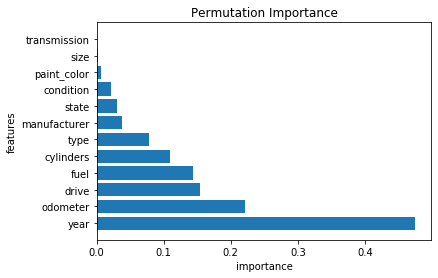

In [27]:
p_impt_result = pd.DataFrame({"Feature": X_trainval_complete.columns.to_list(), 
                             "importances_mean": p_impt['importances_mean'],
                             "importances_std": p_impt['importances_std']}).sort_values(by=['importances_mean'], 
                                                                                          ascending=False)
p_impt_result
plt.barh(p_impt_result['Feature'], p_impt_result['importances_mean'])
plt.title("Permutation Importance");
plt.xlabel("importance");
plt.ylabel("features");

* `Year` is the most important feature to the model, followed by `odometer` and `drive`.
* `transmission`, `size`, and `paint_color` have the least degree of importance. 

### Using Random Forest to select features {-}

We use random forest to select features for the best model (Gradient Boositng). After the pre-processing, there are 90 features in the best Gradeint Boosting model from the task 4. 

In [28]:
## Best model from task 4
best_model = best_grid.best_estimator_.named_steps['transformedtargetregressor']

## Process data
target=['state']
continuous=['odometer']
categorical=['fuel','transmission','drive', 'type',
             'manufacturer','paint_color', 'cylinders','condition', 'size']

cat_preprocessing = Pipeline([('cat_imp',SimpleImputer(missing_values=np.nan, 
                                                       strategy='most_frequent')),
                              ('cat_pre',OneHotEncoder(handle_unknown ='ignore'))])
cont_preprocessing=Pipeline([('cont_imp',SimpleImputer(missing_values=np.nan, 
                                                       strategy='mean')),
                             ('cont_pre',StandardScaler())])

preprocess = make_column_transformer((cat_preprocessing,categorical),
                                     (cont_preprocessing,continuous),
                                     (TargetEncoder(),target),
                                     remainder='passthrough')

preprocess.fit(X_trainval_complete, y_trainval_complete)
X_trainval_processed = preprocess.transform(X_trainval_complete)

In [29]:
#' Find the number of features to keep at various thresholds
thresholds = [1e-1, 1e-2, 1e-3, 1e-4, 0]
result = []
pipe_list = []
select_rf_list = []
for i in thresholds:

    select_rf = SelectFromModel(RandomForestRegressor(random_state = 0), threshold=i)

    pipe_rf = Pipeline([('preprocess',preprocess),
                        ('feature_selection',select_rf),
                        ('regressor', best_model)])
    pipe_list.append(pipe_rf)
    
    mean_score = np.mean(cross_val_score(pipe_rf, X_trainval_complete, y_trainval_complete, cv=10))
    
    select_rf.fit(X_trainval_processed, y_trainval_complete)
    select_rf_list.append(select_rf)
    
    result.append((select_rf.transform(X_trainval_processed).shape[1] , mean_score))

In [30]:
result_df = {"threshold": thresholds, "mean_R2": [r for (_,r) in result], 
             "num_feature": [n for (n,_) in result]}
pd.DataFrame(result_df)

,threshold,mean_R2,num_feature
0,0.1000,0.521624,3
1,0.0100,0.737598,9
2,0.0010,0.758367,48
3,0.0001,0.759433,75
4,0.0000,0.762149,90


There are initially 90 features in total. Removing subsets of features lowers the model performace. Using SelectFromModel(), we find that there are 9 features that, when included in the model, can perform as acceptably well (\\(R^2 = 0.74\\)) as including all features (\\(R^2=0.76\\)). The 9 features are `year`, `state`, `odometer`, and levels `fuel_diesel`, `drive_4wd`, `drive_fwd`, `type_pickup`, `cylinders_4.0`, and `cylinders_8.0`.

In [31]:
#' Get feature names
#' order matters!
features = pipe_rf.named_steps['preprocess'].transformers_[0][1]\
                    .named_steps['cat_pre'].get_feature_names(categorical).tolist()+\
                    ['odometer']+target+['year']
picked_index = 1  
feature_names = []
for pipe in select_rf_list:
    
    mask = pipe.get_support().tolist()
    feature_names.append([x for x,y in zip(features,mask) if y==True])
print("Features: ", feature_names[picked_index])

Features:  ['fuel_diesel', 'drive_4wd', 'drive_fwd', 'type_pickup', 'cylinders_4.0', 'cylinders_8.0', 'odometer', 'state', 'year']


In [32]:
pipe_list[picked_index].fit(X_trainval_complete, y_trainval_complete)
print("Test score (with 9 features): {:.3f}"\
      .format(pipe_list[picked_index].score(global_X_test_complete, 
                                            global_y_test_complete)))

Test score (with 9 features): 0.751


## Task 6 An Explanable Model {-}

### Feature Selection on Linear Regression Model {-}

We use a linear regression to model the price. We still use random forest to select features to include in the model. (In addition to linear regression, we tried a Decision Tree Regressor, but it did not do as well as a linear regression model–code not shown.)

In [33]:
thresholds = [1e-1, 1e-2, 1e-3, 1e-4, 0]
result = []
pipe_list = []
select_rf_list = []
for i in thresholds:

    select_rf = SelectFromModel(RandomForestRegressor(random_state = 0), threshold=i)

    pipe_rf = Pipeline([('preprocess',preprocess),
                        ('feature_selection',select_rf),
                        ('lr', LinearRegression())])
    pipe_list.append(pipe_rf)
    
    mean_score = np.mean(cross_val_score(pipe_rf, X_trainval_complete, y_trainval_complete, cv=10))
    
    select_rf.fit(X_trainval_processed, y_trainval_complete)
    select_rf_list.append(select_rf)
    
    result.append((select_rf.transform(X_trainval_processed).shape[1] , mean_score))
    

In [34]:
result_df = {"threshold": thresholds, "mean_R2": [r for (_,r) in result], 
             "num_feature": [n for (n,_) in result]}
pd.DataFrame(result_df)

,threshold,mean_R2,num_feature
0,0.1000,0.456637,3
1,0.0100,0.631636,9
2,0.0010,0.647773,48
3,0.0001,0.644975,75
4,0.0000,0.644406,90


Including only a subset of features decreases \\(R^2\\) a bit. There are initially 90 features in total. Using SelectFromModel(), we find that the model can perform eqaully well (\\(R^2 = 0.63\\)) when we include the same set of 9 features. The test score of this explanable linear regression model is 0.65.

In [35]:
#' use the same `features` as defined in task 5
picked_index = 1
feature_names = []
for pipe in select_rf_list:
    
    mask = pipe.get_support().tolist()
    feature_names.append([x for x,y in zip(features,mask) if y==True])
print("Features: ", feature_names[picked_index])

Features:  ['fuel_diesel', 'drive_4wd', 'drive_fwd', 'type_pickup', 'cylinders_4.0', 'cylinders_8.0', 'odometer', 'state', 'year']


In [36]:
pipe_list[picked_index].fit(X_trainval_complete, y_trainval_complete)
print("Test score (with 9 features): {:.3f}".format(pipe_list[picked_index].score(global_X_test_complete, global_y_test_complete)))

Test score (with 9 features): 0.651


In [40]:
coef = pipe_list[picked_index].named_steps['lr'].coef_
summary = pd.DataFrame({'feature':feature_names[picked_index],'coeficient':coef, 'abs_coeficient': abs(coef), 'sign': np.sign(coef)})\
                .sort_values('abs_coeficient',ascending=False)
summary[['feature', 'coeficient']]

,feature,coeficient
0,fuel_diesel,10742.306744
6,odometer,-4390.743649
3,type_pickup,3844.836846
4,cylinders_4.0,-3269.629275
2,drive_fwd,-3013.130615
5,cylinders_8.0,2326.934339
1,drive_4wd,2146.409037
8,year,449.830533
7,state,0.415440


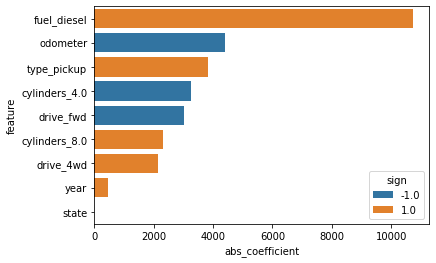

In [38]:
sns.barplot(x=summary['abs_coefficient'], y=summary['feature'], hue = summary['sign'],dodge=False);

On average

* A car that takes diesel has higher price set.
* The further a car has run (odometer), the lower the price.
* A car with 8 cylinders has higher price and a car with 4 cylinders has lower price.
* The newer a car, the higher the price.